# long-short-portfolio

On the first trading day of every month, rebalance portfolio to given percentages.  One of the positions is a short position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
portfolio_option = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}

directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}

Some global data

In [4]:
symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
}
options

{'use_adj': True, 'use_cache': True}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts)

In [7]:
pf.TradeLog.cash = capital

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        portfolio.print_holdings(row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(row, weights, field='close', directions=directions)

    # Record daily balance.
    portfolio.record_daily_balance(row)

2004-12-01 SPY:  0 GLD:  0 TLT:  0 TLT_SHRT:  0 cash: 10,000.00 total: 10,000.00
2005-01-03 SPY: 60 GLD: 22 TLT: 63 TLT_SHRT: 21 cash:    57.87 total: 10,076.79
2005-02-01 SPY: 60 GLD: 23 TLT: 61 TLT_SHRT: 20 cash:   158.95 total: 10,061.60
2005-03-01 SPY: 60 GLD: 23 TLT: 59 TLT_SHRT: 19 cash:   304.62 total: 10,156.90
2005-04-01 SPY: 60 GLD: 23 TLT: 61 TLT_SHRT: 20 cash:   154.99 total: 10,002.05
2005-05-02 SPY: 61 GLD: 23 TLT: 60 TLT_SHRT: 20 cash:   122.95 total: 10,033.90
2005-06-01 SPY: 61 GLD: 23 TLT: 58 TLT_SHRT: 19 cash:   269.89 total: 10,266.39
2005-07-01 SPY: 61 GLD: 24 TLT: 57 TLT_SHRT: 19 cash:   282.29 total: 10,267.76
2005-08-01 SPY: 61 GLD: 24 TLT: 57 TLT_SHRT: 19 cash:   282.29 total: 10,401.96
2005-09-01 SPY: 60 GLD: 24 TLT: 59 TLT_SHRT: 19 cash:   264.28 total: 10,447.10
2005-10-03 SPY: 60 GLD: 23 TLT: 58 TLT_SHRT: 19 cash:   362.49 total: 10,444.45
2005-11-01 SPY: 60 GLD: 22 TLT: 60 TLT_SHRT: 20 cash:   252.74 total: 10,307.00
2005-12-01 SPY: 60 GLD: 22 TLT: 60 TLT_

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,45.38,22,entry,LONG,GLD
0,2004-12-01,1,47.55,21,entry,SHRT,TLT_SHRT
0,2004-12-01,2,47.55,63,entry,LONG,TLT
0,2004-12-01,3,82.49,60,entry,LONG,SPY
1,2005-01-03,4,49.00,2,exit,LONG,TLT
1,2005-01-03,5,49.00,1,exit,SHRT,TLT_SHRT
1,2005-01-03,6,43.02,1,entry,LONG,GLD
2,2005-02-01,7,50.56,2,exit,LONG,TLT
2,2005-02-01,8,50.56,1,exit,SHRT,TLT_SHRT
3,2005-03-01,9,49.88,2,entry,LONG,TLT


In [10]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
60,2017-10-02,120.77,2022-10-03,158.43,37.66,37.66,1,22324.28,LONG,GLD
126,2017-10-02,107.63,2023-12-20,99.56,-8.07,-16.14,2,22308.14,LONG,TLT
64,2017-10-02,107.63,2023-12-20,99.56,8.07,8.07,1,22316.21,SHRT,TLT_SHRT
61,2017-12-01,121.59,2023-01-03,171.06,49.47,49.47,1,22365.68,LONG,GLD
127,2018-01-02,109.36,2023-12-20,99.56,-9.80,-9.80,1,22355.87,LONG,TLT
...,...,...,...,...,...,...,...,...,...,...
161,2023-06-01,100.93,2023-12-20,99.56,-1.37,-5.50,4,27260.16,LONG,TLT
80,2023-07-03,178.47,2023-12-20,188.10,9.63,19.26,2,27279.42,LONG,GLD
162,2023-07-03,100.19,2023-12-20,99.56,-0.63,-1.25,2,27278.16,LONG,TLT
163,2023-08-01,96.59,2023-12-20,99.56,2.97,20.82,7,27298.98,LONG,TLT


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2023-12-14,40802.21,40802.21,40802.21,220,49.13,1.00,-
2023-12-15,40744.12,40744.12,40744.12,220,49.13,1.00,-
2023-12-18,40804.33,40804.33,40804.33,220,49.13,1.00,-
2023-12-19,41000.51,41000.51,41000.51,220,49.13,1.00,-
2023-12-20,37328.99,37328.99,37328.99,0,37328.99,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2023-12-20
beginning_balance                                           10000
ending_balance                                           37328.99
total_net_profit                                         27328.99
gross_profit                                             32285.47
gross_loss                                               -4956.48
profit_factor                                                6.51
return_on_initial_capital                                  273.29
annual_return_rate                                           7.15
trading_period                           19 years 1 months 2 days
pct_time_in_market                                          99.83
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

,cumul_total,weight,pct_cumul_total,relative_performance
SPY,"$22,653.78",0.50,0.83,1.66
GLD,"$2,798.26",0.10,0.10,1.02
TLT,"$2,760.76",0.30,0.10,0.34
TLT_SHRT,-$883.82,0.10,-0.03,-0.32
TOTAL,"$27,328.99",1.00,1.00,1.00


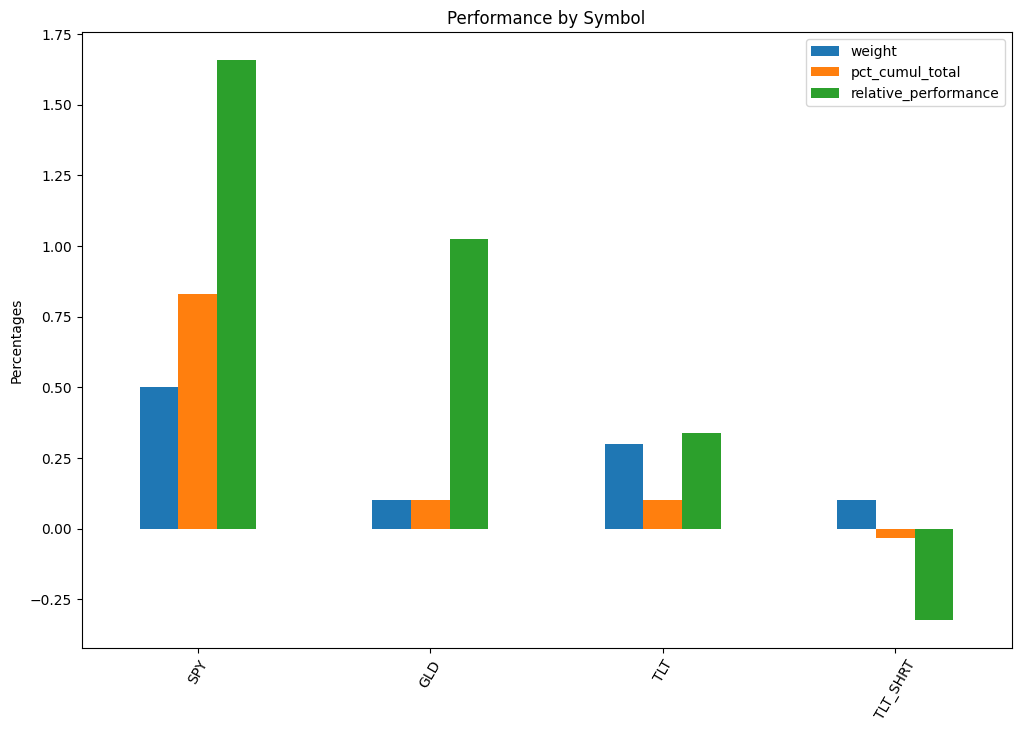

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

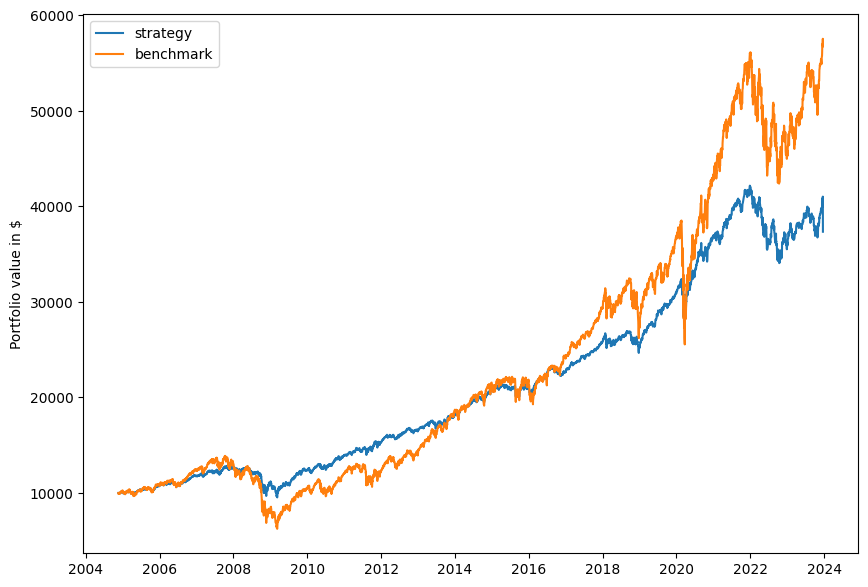

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [16]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$37,328.99","$56,719.20"
total_net_profit,"$27,328.99","$46,719.20"
gross_profit,"$32,285.47","$46,719.20"
gross_loss,"-$4,956.48",$0.00


,strategy,benchmark
annual_return_rate,7.15,9.52
max_closed_out_drawdown,-25.71,-54.95
annualized_return_over_max_drawdown,0.28,0.17
best_month,14.20,23.40
worst_month,-15.59,-30.94
sharpe_ratio,0.79,0.57
sortino_ratio,0.96,0.69
monthly_std,2.37,4.54
annual_std,8.40,16.27


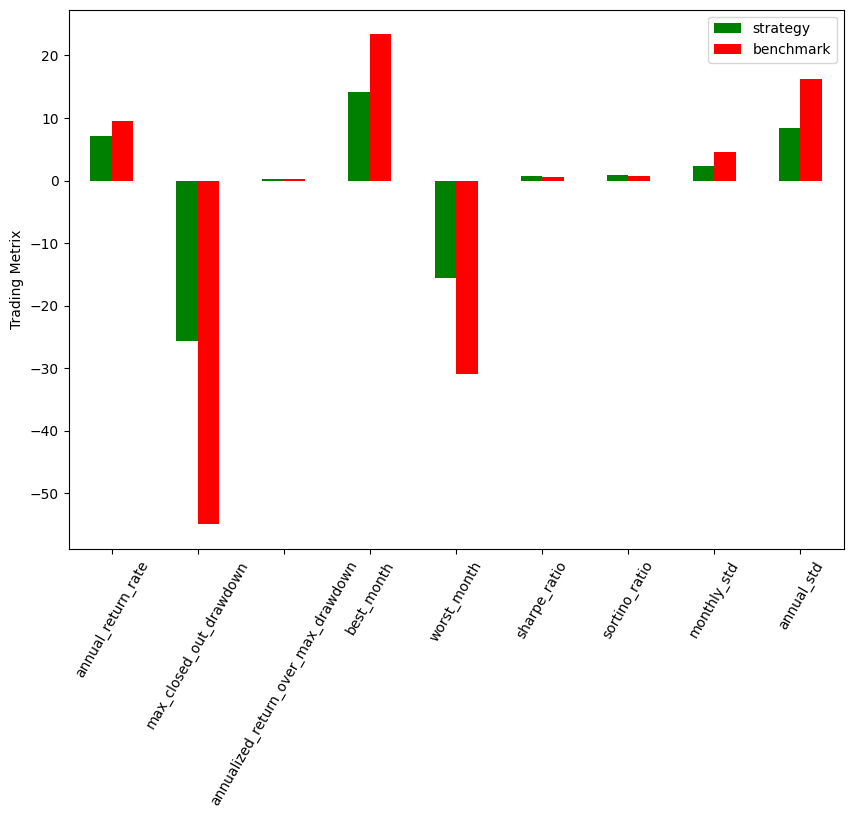

In [17]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df